In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

2025-04-08 13:52:04.705558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 13:52:04.729066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744131124.754021   48389 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744131124.763532   48389 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744131124.787200   48389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54

In [2]:
from IPython.display import clear_output
import warnings

In [3]:
# download dataset from
# https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

import os
import subprocess
import zipfile
import shutil

# Criar diretório data se não existir
if not os.path.exists('data'):
    os.makedirs('data')
    print("Pasta 'data/' criada.")

# URL do dataset
url = "https://www.kaggle.com/api/v1/datasets/download/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"

# Nome do arquivo zip
zip_file = "archive.zip"

try:
    # Baixar o arquivo usando wget
    print("Baixando o dataset...")
    wget_command = f"wget {url} -O {zip_file}"
    subprocess.run(wget_command, shell=True, check=True)
    print("Download concluído!")
    
    # Descompactar o arquivo
    if os.path.exists(zip_file):
        print(f"Descompactando {zip_file}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('temp_imdb')
        
        # Mover o CSV para a pasta data/
        for file in os.listdir('temp_imdb'):
            if file.endswith('.csv'):
                src = os.path.join('temp_imdb', file)
                dst = os.path.join('data', file)
                shutil.move(src, dst)
                print(f"Arquivo {file} movido para data/")
        
        # Limpar arquivos temporários
        shutil.rmtree('temp_imdb')
        os.remove(zip_file)
        print("Arquivos temporários removidos.")
        
        clear_output(wait=True)
        print("'IMDB Dataset.csv' salvo com sucesso em data/")
    else:
        print(f"Erro: Arquivo {zip_file} não foi baixado corretamente.")
        
except subprocess.CalledProcessError as e:
    print(f"Erro ao baixar o arquivo: {e}")
except Exception as e:
    print(f"Erro durante o processamento: {e}")

'IMDB Dataset.csv' salvo com sucesso em data/


In [3]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
import re

def remove_html_tags(text):
    """
    Remove HTML tags from a string.
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_special_characters(text):
    """
    Remove special characters from a string.
    """
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

def remove_extra_spaces(text):
    """
    Remove extra spaces from a string.
    """
    return re.sub(r'\s+', ' ', text).strip()
def to_lowercase(text):
    """
    Convert a string to lowercase.
    """
    return text.lower()
def preprocess_text(text):
    """
    Preprocess the input text by removing HTML tags, special characters,
    extra spaces, and converting to lowercase.
    """
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = remove_extra_spaces(text)
    text = to_lowercase(text)
    return text

df['clean_review'] = df['review'].apply(preprocess_text)
df['clean_review'].iloc[0]

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictur

In [7]:
# split into 25k train and 25k test
train = df[:25000]
test = df[25000:]

In [8]:
# reduce dataset to 2,5k train and 2,5k test
#train = train[:2500]
#test = test[:2500]

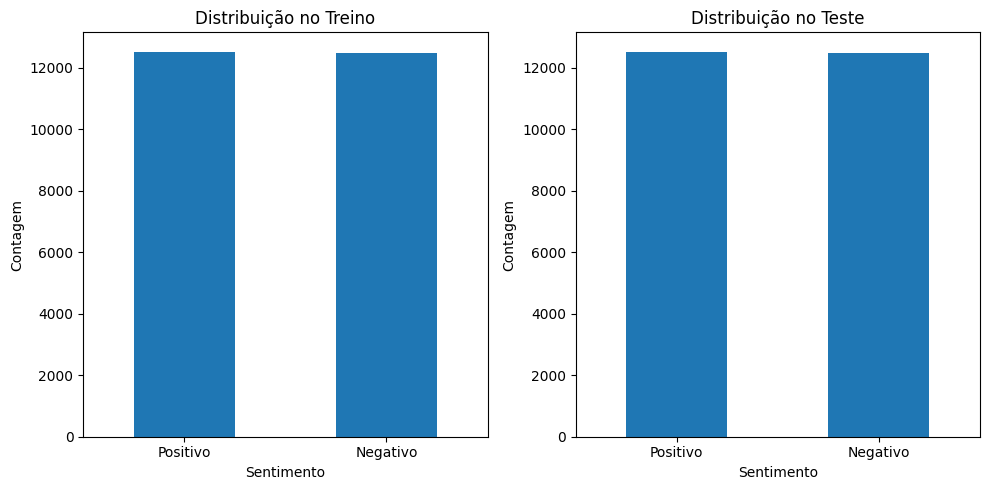

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# check distribution 
train['sentiment'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribuição no Treino')
ax[0].set_xlabel('Sentimento')
ax[0].set_ylabel('Contagem')
ax[0].set_xticklabels(['Positivo', 'Negativo'], rotation=0)

test['sentiment'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Distribuição no Teste')
ax[1].set_xlabel('Sentimento')
ax[1].set_ylabel('Contagem')
ax[1].set_xticklabels(['Positivo', 'Negativo'], rotation=0)
plt.tight_layout()
plt.show()

In [10]:
for i in range(5):
    print('Texto:', train['clean_review'].values[i])
    print('Sentimento:', train['sentiment'].values[i])
    print('---')

Texto: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty 

In [11]:
from keras_hub.tokenizers import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

/home/erlo/.localvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://javilopezcastillo.medium.com/sentiment-analysis-using-lstm-networks-a-deep-dive-into-textual-data-61cdd2e43dec

In [12]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))
    
    max_length = int(np.ceil(np.mean(review_length)))
    return max_length

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

VOCAB_SIZE = 10000

tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(train['clean_review'])

# Convert the text to sequences
train_sequences = tokenizer.texts_to_sequences(train['clean_review'])
test_sequences = tokenizer.texts_to_sequences(test['clean_review'])

In [14]:
len(train_sequences[1])

144

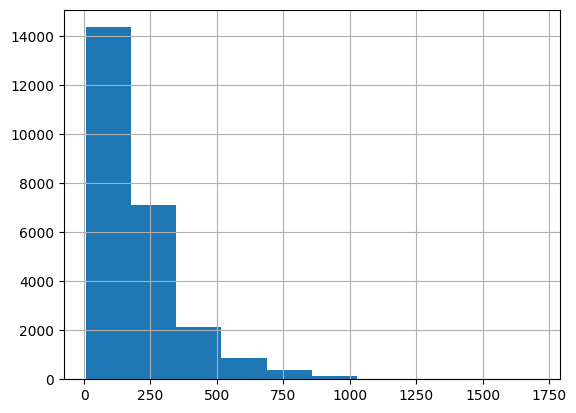

count    25000.000000
mean       210.378160
std        153.815341
min          8.000000
25%        116.000000
50%        159.000000
75%        256.000000
max       1704.000000
dtype: float64

In [15]:
review_len = [len(x) for x in train_sequences]
pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

In [16]:
# get top 5% longest reviews
top_5_percent = np.percentile(review_len, 95)
print('Top 5%:', top_5_percent)

# all reviews with len above this number are just too big

Top 5%: 536.0499999999993


In [17]:
# Pad the sequences
MAX_LENGTH = int(np.floor(top_5_percent))

train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

# Convert the labels to binary
train_labels = np.where(train['sentiment'] == 'positive', 1, 0)
test_labels = np.where(test['sentiment'] == 'positive', 1, 0)

In [18]:
train_sequences

array([[   0,    0,    0, ...,  120, 3881,  503],
       [   0,    0,    0, ..., 1878,   71,  218],
       [   0,    0,    0, ...,   63,   14,  323],
       ...,
       [   0,    0,    0, ...,  225,  218,  229],
       [   0,    0,    0, ..., 3152,    2,  904],
       [   0,    0,    0, ...,  406,   49, 3311]], dtype=int32)

In [19]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from keras import regularizers
from keras.optimizers import Adam
from keras.layers import BatchNormalization 
from keras.callbacks import ModelCheckpoint

In [20]:
EMBED_DIM = 100
LSTM_OUT_NUM = 128

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [22]:
def now():
    from datetime import datetime
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [23]:
model = Sequential()

model.add(Embedding(
    input_dim=tokenizer.num_words,
    output_dim=EMBED_DIM,
    input_length=MAX_LENGTH
))
model.add(LSTM(LSTM_OUT_NUM))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/home/erlo/.localvenv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-08 13:52:30.072788: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
checkpoint = ModelCheckpoint(
    f'data/best_model_{now()}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

history = model.fit(
    train_sequences,
    train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10


2025-04-08 14:37:47.682235: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 235s 744ms/step - accuracy: 0.6671 - loss: 0.5806 - val_accuracy: 0.8034 - val_loss: 0.5326
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 232s 742ms/step - accuracy: 0.8751 - loss: 0.3224 - val_accuracy: 0.8594 - val_loss: 0.3535
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 241s 770ms/step - accuracy: 0.9159 - loss: 0.2275 - val_accuracy: 0.8622 - val_loss: 0.3721
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 264s 777ms/step - accuracy: 0.9402 - loss: 0.1738 - val_accuracy: 0.8634 - val_loss: 0.3537
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 236s 753ms/step - accuracy: 0.9566 - loss: 0.1270 - val_accuracy: 0.8632 - val_loss: 0.4163
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 257s 738ms/step - accuracy: 0.9648 - loss: 0.1037 - val_accuracy: 0.8580 - val_loss: 0.4627
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 266s 750ms/step - accuracy: 0.9708 - loss: 0.0880 - val_accuracy: 0.8572 - val_loss: 0.5138
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


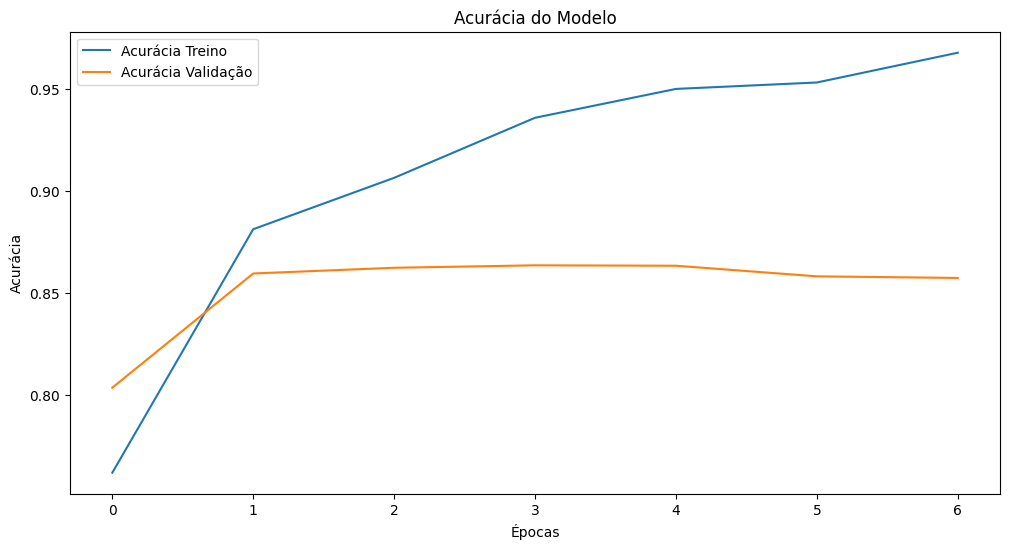

In [ ]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negativo', 'Positivo'],
                yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')
    plt.show()

In [30]:
y_pred = model.predict(test_sequences)
y_pred = np.where(y_pred > 0.5, 1, 0)

782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 185ms/step


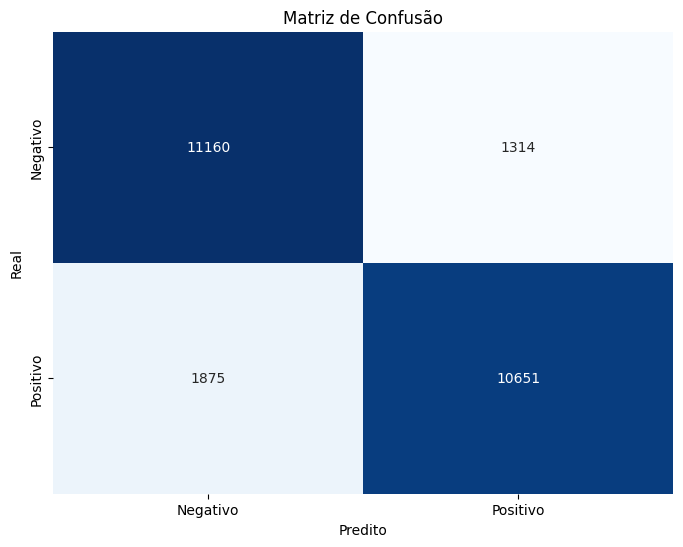

              precision    recall  f1-score   support

    Negativo       0.86      0.89      0.87     12474
    Positivo       0.89      0.85      0.87     12526

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [31]:
plot_confusion_matrix(test_labels, y_pred)
print(classification_report(test_labels, y_pred, target_names=['Negativo', 'Positivo']))

## Testing

In [32]:
from keras.models import load_model

loaded_model = load_model('data/model_2025-04-08 15_54_18.keras')
loaded_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 536, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

In [34]:
review = "Liked it a lot, very good movie"
review = "Bad movie I didn´t like it bad bad bad shit"
review = "Shit movie I didn´t like it at all. The director was terrible and the plot made no sense. I would like to see him in person and tell how shit this movie was. 0 stars for this" 
review = "This movie was fantastic and I loved it! Very well done and the actors were great. I would recommend it to everyone." 
review = preprocess_text(review)
review = tokenizer.texts_to_sequences([review])
review = pad_sequences(review, maxlen=MAX_LENGTH)
prediction = loaded_model.predict(review)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[[0.9885075]]


In [49]:
# select random indices from dataset
np.random.seed(41)

random_indices = np.random.choice(len(test), size=5, replace=False)

test.iloc[random_indices]

,review,sentiment,clean_review
42413,this movie was incredibly stupid with meaning ...,negative,this movie was incredibly stupid with meaning ...
43578,Like a very expensive Buffy episode peppered w...,positive,like a very expensive buffy episode peppered w...
34109,What a dreadful film this is. The only reason ...,negative,what a dreadful film this is the only reason y...
28274,Cam Archer's lyrical Bobbycrush boldly capture...,positive,cam archers lyrical bobbycrush boldly captures...
32965,The last reviewer was very generous. I quiet l...,negative,the last reviewer was very generous i quiet li...


In [52]:
neg_review = test.iloc[random_indices[0]]['review']
pos_review = test.iloc[random_indices[-2]]['review']

In [53]:
def classify_review(review):
    review = preprocess_text(review)
    review = tokenizer.texts_to_sequences([review])
    review = pad_sequences(review, maxlen=MAX_LENGTH)
    prediction = loaded_model.predict(review)
    return "positive" if prediction[0] > 0.5 else "negative"

In [56]:
print(f'Review: {neg_review}\nClassificação: {classify_review(neg_review)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Review: this movie was incredibly stupid with meaning what so ever. i fell bad for all the actors and actresses that ruined there career to be in this stupid movie. the entire movie was based on how unrealistic they could make it, to make little like it which made it even stupider. even some of the names were unrealistic. the film is fun to watch which is why it had 2 out of 10 stars. this is probably the 3rd stupidest movie ever made. i got really made after i realized that it had mostly adult actors in it yet in was a kid movie. the most upsetting one was Danny Trejo a horror movie actor who is always dirty. the other actors were pretty much clean as far as i'm concerned.
Classificação: negative


In [57]:
print(f'Review: {pos_review}\nClassificação: {classify_review(pos_review)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Review: Cam Archer's lyrical Bobbycrush boldly captures the disorienting kaleidoscope that is adolescent desire with a lush rendering (beautifully photographed by Aaron Platt) that is more vibe than narrative. Caught somewhere between documentary and dream, Bobbycrush recalls the inventiveness of early Todd Haynes and the vivid hyperrealism of Gus van Sant. With grit, glamour and heartbreak, it's kinda like the movie equivalent of Sonic Youth playing bubblegum pop.
Classificação: positive
